# Imports

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

# Check GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Datasets

In [19]:
batch_size = 32
img_size = (256, 256)

ROOT_PATH = './drive/MyDrive/Colab Drive/hotdogclassifier'
train_dir = os.path.join(ROOT_PATH, 'train')
test_dir = os.path.join(ROOT_PATH, 'test')

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=8,
                                             batch_size=batch_size,
                                             image_size=img_size)

validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=batch_size,
                                             image_size=img_size)

test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=batch_size,
                                             image_size=img_size)

class_names = train_dataset.class_names
print(class_names)


Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Found 644 files belonging to 2 classes.
['hotdog', 'nothotdog']


# Visualize Data

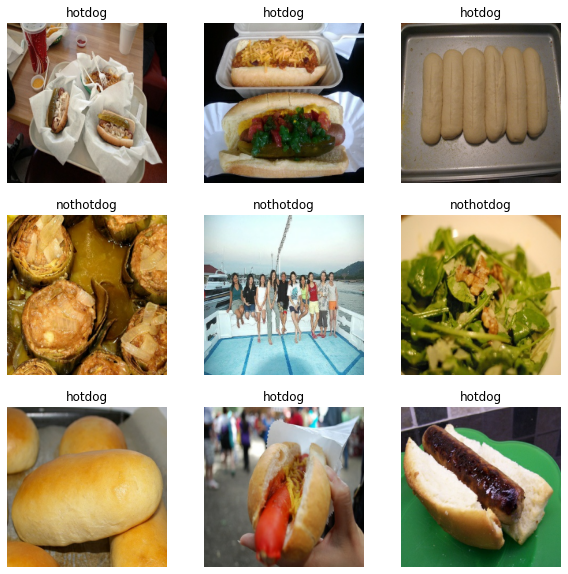

In [9]:
plt.figure(figsize=(10, 10))
for ind, (images, labels) in enumerate(train_dataset):
    if ind > 0: break
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation Function

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

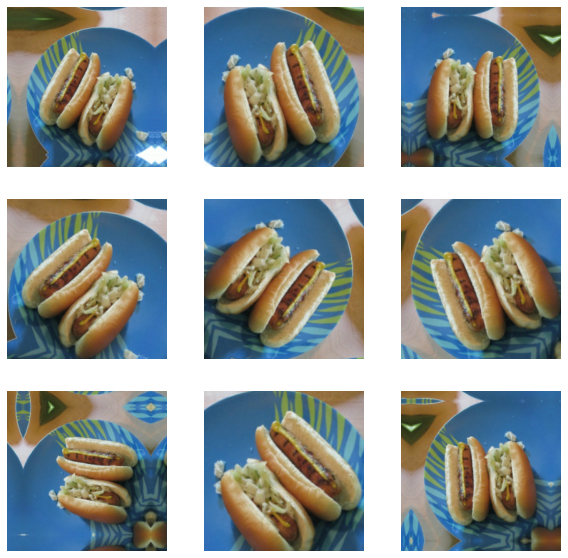

In [14]:
for ind, (image, _) in enumerate(train_dataset):
    if ind > 0: break
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Learning Curve Plotting Function

In [15]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# Define Model

In [16]:
base_model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (256,256,3))
base_model_inception_resnet_v2.trainable = False
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model_inception_resnet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_resnet_v2 = tf.keras.Model(inputs, outputs, name='inception_resnet_v2')

model_inception_resnet_v2.summary()


Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                               

# Compile and Train Model

Epoch 1/10
75/75 [==============================] - 196s 2s/step - loss: 0.2955 - accuracy: 0.8904 - val_loss: 0.1728 - val_accuracy: 0.9450
Epoch 2/10
75/75 [==============================] - 25s 322ms/step - loss: 0.2120 - accuracy: 0.9175 - val_loss: 0.1312 - val_accuracy: 0.9433
Epoch 3/10
75/75 [==============================] - 24s 313ms/step - loss: 0.1994 - accuracy: 0.9217 - val_loss: 0.1202 - val_accuracy: 0.9550
Epoch 4/10
75/75 [==============================] - 24s 311ms/step - loss: 0.1850 - accuracy: 0.9217 - val_loss: 0.1267 - val_accuracy: 0.9450
Epoch 5/10
75/75 [==============================] - 24s 317ms/step - loss: 0.1729 - accuracy: 0.9400 - val_loss: 0.1368 - val_accuracy: 0.9483


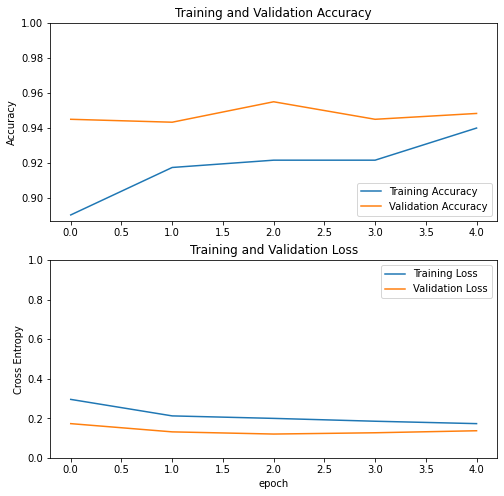

In [17]:
model_inception_resnet_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_inception_resnet_v2 = model_inception_resnet_v2.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])

plotLearningCurve(history_inception_resnet_v2)

model_inception_resnet_v2.save('model_inception_resnet_v2.h5')

# Test Dataset

21/21 [==============================] - 63s 2s/step - loss: 0.1044 - accuracy: 0.9596


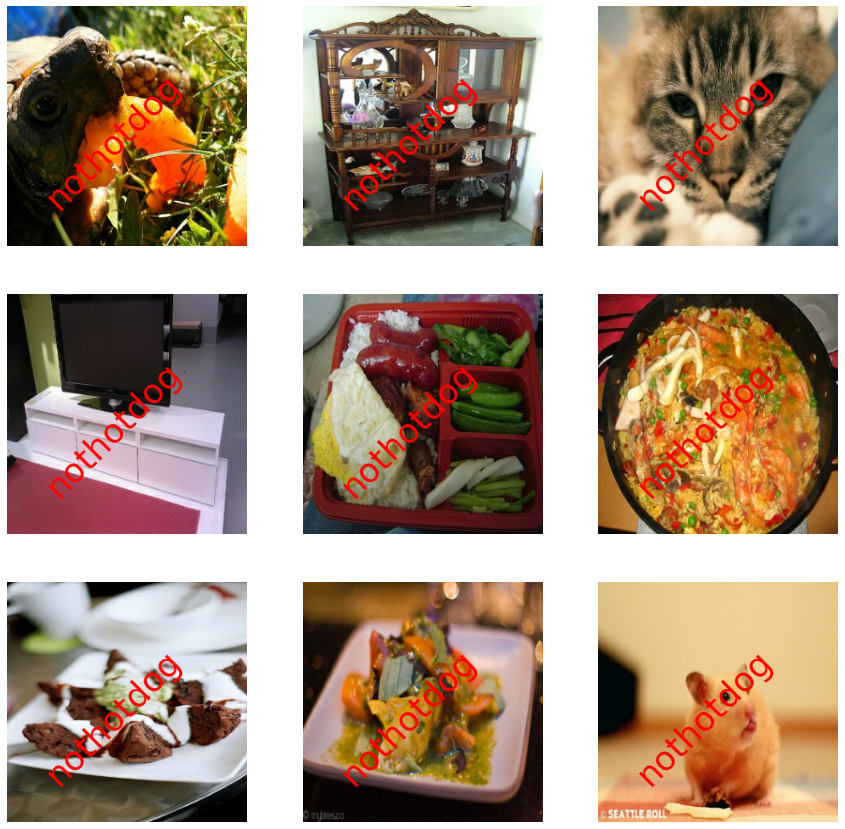

In [20]:
model_inception_resnet_v2.evaluate(test_dataset)

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_inception_resnet_v2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='Hot Dog':
        plt.text(50, 200, label, rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")

# Convert to TFJS

In [24]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.0 MB/s 
     |████████████████████████████████| 40 kB 6.5 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [37]:
command = "tensorflowjs_converter --input_format=keras ./model_inception_resnet_v2.h5 ./tfjs_model"
print(command)

tensorflowjs_converter --input_format=keras ./model_inception_resnet_v2.h5 ./tfjs_model


In [38]:
!{command}

In [39]:
!tar -czf model.tar.gz ./tfjs_model